<a href="https://colab.research.google.com/github/mvfolino68/CFPB_complaints_notebook/blob/master/CFPB_Text_Topic_Extraction_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CFPB Text Analytics

![alt text](https://www.consumerfinance.gov/static/img/logo_237x50.c7c2ba6c929f.png)

---


#Our Problem - Identify Common Topics in Customer Complaints to Consumer Financial Protection Bureau


---


#Our Solution - Use Natural Language Processing to Extract Repeated Topics and Rank Sentiments

---




##Import Modules

In [0]:
!pip install pyLDAvis
# Usual imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os


# Plotly based imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg

##Import the Data

In [2]:
df = pd.read_csv('https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD', encoding='utf-8')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/15/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",CA,95503,NaN,Consent not provided,Web,05/15/2019,Closed with explanation,Yes,NaN,3243010
1,05/15/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,ALLY FINANCIAL INC.,CA,945XX,NaN,NaN,Web,05/15/2019,In progress,Yes,NaN,3242607
2,05/15/2019,Debt collection,Payday loan debt,Threatened to contact someone or share informa...,Contacted your employer,NaN,NaN,F&M Capital LLC,MI,NaN,NaN,NaN,Web,05/15/2019,Closed with explanation,Yes,NaN,3242659
3,05/15/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,ALLY FINANCIAL INC.,TN,370XX,NaN,NaN,Web,05/15/2019,In progress,Yes,NaN,3242618
4,05/15/2019,Debt collection,Other debt,Communication tactics,"You told them to stop contacting you, but they...",NaN,NaN,"Diversified Consultants, Inc.",MA,017XX,NaN,NaN,Web,05/15/2019,In progress,Yes,NaN,3243098


##Pre Process and Explore the Data

###Function creation for preprocessing

In [0]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')
#create word lemmetizer object, stopwords
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):

    mytokens = [char for char in sentence if char not in ['X']]
    

    # Join the characters again to form the string.
    mytokens = ''.join(mytokens)
    mytokens = parser(mytokens)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations and word.isalpha()]
    mytokens = " ".join([i for i in mytokens]).replace(' m t ', ' ')  
    return mytokens

###Pre Processing data

In [0]:
tqdm.pandas()
bank_name = 'M&T BANK CORPORATION'
df = df[pd.notnull(df['Consumer complaint narrative'].str.strip())]
df =df[df['Company'].str.contains(bank_name)]
#clean cols
df['Consumer complaint narrative clean'] = df['Consumer complaint narrative'].apply(spacy_tokenizer)

In [0]:
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace = True)

###Check the cleaned text

In [6]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Consumer complaint narrative clean
0,03/13/2019,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,I purchased a condo on XX/XX/XXXX in XXXX XXXX...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,NaN,NaN,NaN,Consent provided,Web,03/14/2019,Closed with explanation,Yes,NaN,3179148,purchase condo ny late husband mortgage monthl...
1,03/05/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,i have a mortgage payment due by the XXXX othe...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,FL,NaN,Older American,Consent provided,Web,03/05/2019,Closed with explanation,Yes,NaN,3169543,mortgage payment late payment work anymore med...
2,03/04/2019,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,My mortgage was initially a fixed rate mortgag...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,SC,NaN,NaN,Consent provided,Web,03/04/2019,Closed with non-monetary relief,Yes,NaN,3168442,mortgage initially fix rate mortgage switch ba...
3,03/03/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,My mortgage company M & T Bank has refused pay...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,AZ,853XX,NaN,Consent provided,Web,03/03/2019,Closed with explanation,Yes,NaN,3167681,mortgage company bank refuse payment run check...
4,03/01/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,According to my understanding of the Homeowner...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,TN,371XX,NaN,Consent provided,Web,03/01/2019,Closed with explanation,Yes,NaN,3166538,according understand homeowners protection act...


In [0]:
print(df.shape)
print(df.columns)

(741, 20)
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID',
       'Consumer complaint narrative clean', 'year'],
      dtype='object')


##Explore the Summary Stats by Year and Feature

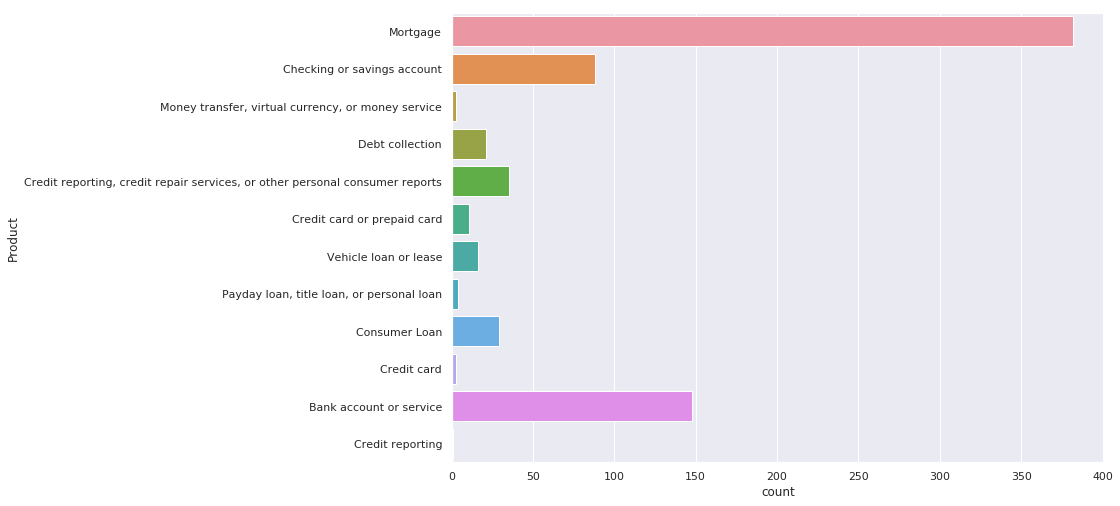

In [14]:
g = sns.countplot(y = 'Product', data = df)

###define function to view topics

In [0]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

##Analysis

###Select and Apply Algorithm


In [0]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True#, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'
                             , ngram_range=(1,3))
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True#, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'
                                   , ngram_range=(1,3))

#vectorize q9
data_vectorized_tfidf = tfidf_vectorizer.fit_transform(df['Consumer complaint narrative clean'])
data_vectorized = vectorizer.fit_transform(df['Consumer complaint narrative clean'])

In [17]:
#define our 3 topic models
NUM_TOPICS = 10
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized_tfidf)

# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS, alpha=.1, l1_ratio=.5)
data_nmf = nmf.fit_transform(data_vectorized_tfidf) 

# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized_tfidf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


###Review results of 3 different approaches to topic extraction

In [18]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, tfidf_vectorizer)

LDA Model:
Topic 0:
['payment', 'account', 'bank', 'vehicle', 'report', 'collection', 'finance', 'thanks', 'late', 'cash']
Topic 1:
['inquiry', 'account', 'representative', 'remove credit', 'credit report', 'bank', 'product', 'help', 'remove credit report', 'atm']
Topic 2:
['payment', 'bank', 'mortgage', 'loan', 'pay', 'credit', 'late', 'tell', 'receive', 'time']
Topic 3:
['account', 'bank', 'fee', 'estate', 'loan', 'saving account', 'escrow', 'month', 'judge', 'close']
Topic 4:
['account', 'bank', 'card', 'deposit', 'charge', 'money', 'check', 'fee', 'open', 'transaction']
Topic 5:
['account', 'mortgage', 'hurricane', 'government', 'bonus', 'send', 'wait', 'internet', 'access', 'decrease']
Topic 6:
['bank violate', 'credit report bureau', 'report bureau', 'fail report', 'information credit', 'accurate', 'activity', 'cease', 'report', 'violate']
Topic 7:
['note', 'bank', 'principal', 'cost', 'feel', 'dispute', 'payment', 'agency', 'account', 'cash']
Topic 8:
['cd', 'inquiry', 'bank', '

In [19]:
# Keywords for topics clustered by Non Negative Matrix Factorization
print("NMF Model:")
selected_topics(nmf, tfidf_vectorizer)

NMF Model:
Topic 0:
['bank', 'letter', 'tell', 'receive', 'check', 'send', 'account', 'request', 'information', 'money']
Topic 1:
['account', 'fee', 'charge', 'overdraft', 'check', 'close', 'balance', 'bank', 'close account', 'transaction']
Topic 2:
['payment', 'late', 'month', 'late fee', 'late payment', 'pay', 'mortgage payment', 'mortgage', 'fee', 'bank']
Topic 3:
['bonus', 'account', 'open', 'deposit', 'direct deposit', 'direct', 'code', 'promotion', 'open account', 'offer']
Topic 4:
['report', 'credit', 'credit report', 'bureau', 'credit bureau', 'late', 'inquiry', 'dispute', 'remove', 'report credit']
Topic 5:
['loan', 'modification', 'loan modification', 'home', 'income', 'mortgage', 'approve', 'foreclosure', 'bank', 'payment']
Topic 6:
['insurance', 'taxis', 'escrow', 'property', 'pay', 'tax', 'property taxis', 'year', 'pmi', 'increase']
Topic 7:
['mortgage', 'mortgage company', 'company', 'mortgage payment', 'pay', 'bankruptcy', 'pay mortgage', 'home', 'time', 'wife']
Topic 8:

In [20]:
# Keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
selected_topics(lsi, tfidf_vectorizer)

LSI Model:
Topic 0:
['bank', 'payment', 'account', 'mortgage', 'loan', 'check', 'pay', 'tell', 'credit', 'fee']
Topic 1:
['account', 'deposit', 'check', 'card', 'open', 'charge', 'bonus', 'money', 'fee', 'check account']
Topic 2:
['payment', 'credit', 'report', 'late', 'credit report', 'fee', 'charge', 'late fee', 'late payment', 'bureau']
Topic 3:
['payment', 'bonus', 'account', 'open', 'direct deposit', 'deposit', 'direct', 'code', 'promotion', 'month']
Topic 4:
['report', 'credit', 'bonus', 'credit report', 'open', 'direct deposit', 'bureau', 'direct', 'code', 'promotion']
Topic 5:
['fee', 'loan', 'charge', 'modification', 'mortgage', 'account', 'overdraft', 'balance', 'loan modification', 'report']
Topic 6:
['mortgage', 'insurance', 'escrow', 'check', 'pay', 'request', 'letter', 'mortgage company', 'receive', 'property']
Topic 7:
['loan', 'payment', 'letter', 'request', 'bank', 'provide', 'fee', 'modification', 'record', 'loan modification']
Topic 8:
['check', 'close', 'account', '

####LDA approach How to interpret this graph?
Topics on the left while their respective keywords are on the right.

Larger topics are more frequent and the closer the topics, the more similar they are

Selection of keywords is based on their frequency and discriminancy.

Hover over the topics on the left to get information about their keywords on the right.

In [25]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized_tfidf, tfidf_vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
2       27.108309  18.672068       1        1  70.661372
4      117.282143  12.207164       2        1  18.998417
6      -20.536385  22.087866       3        1   1.292527
3       91.453560 -32.463203       4        1   1.292526
0       51.800438  64.945518       5        1   1.292526
9       -1.342140 -25.811571       6        1   1.292526
8       98.089020  60.105679       7        1   1.292526
5       44.946903 -30.650585       8        1   1.292526
7        5.294091  66.758377       9        1   1.292526
1       69.637451  15.623151      10        1   1.292526, topic_info=     Category       Freq              Term      Total  loglift  logprob
14    Default  32.000000           account  32.000000  30.0000  30.0000
405   Default  10.000000              card  10.000000  29.0000  29.0000
446   Default  15.000000            charge  15.000000  28.0000  28.0000
727   Default  10.000000           deposit  10.000000  27.0000  27.0000
1419  Default  15.000000             money  15.000000  26.0000  26.0000
460   Default  18.000000             check  18.000000  25.0000  25.0000
904   Default  18.000000               fee  18.000000  24.0000  24.0000
231   Default  43.000000              bank  43.000000  23.0000  23.0000
1570  Default   8.000000              open   8.000000  22.0000  22.0000
2400  Default   7.000000       transaction   7.000000  21.0000  21.0000
372   Default   8.000000            branch   8.000000  20.0000  20.0000
1597  Default   5.000000         overdraft   5.000000  19.0000  19.0000
1282  Default  28.000000              loan  28.000000  18.0000  18.0000
1454  Default  30.000000          mortgage  30.000000  17.0000  17.0000
362   Default   5.000000             bonus   5.000000  16.0000  16.0000
502   Default  12.000000             close  12.000000  15.0000  15.0000
1401  Default  13.000000      modification  13.000000  14.0000  14.0000
1010  Default   9.000000              fund   9.000000  13.0000  13.0000
694   Default   5.000000             debit   5.000000  12.0000  12.0000
461   Default   6.000000     check account   6.000000  11.0000  11.0000
1814  Default  10.000000          property  10.000000  10.0000  10.0000
977   Default  10.000000       foreclosure  10.000000   9.0000   9.0000
2470  Default   8.000000               use   8.000000   8.0000   8.0000
1172  Default   9.000000         insurance   9.000000   7.0000   7.0000
192   Default   4.000000               atm   4.000000   6.0000   6.0000
839   Default   7.000000            escrow   7.000000   5.0000   5.0000
1097  Default   8.000000             house   8.000000   4.0000   4.0000
775   Default   9.000000          document   9.000000   3.0000   3.0000
2067  Default   8.000000              sale   8.000000   2.0000   2.0000
647   Default   9.000000          customer   9.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
2132  Topic10   0.025082     service agent   1.189902   0.4891  -7.8396
2534  Topic10   0.025061    withdraw money   1.111305   0.5566  -7.8404
2153  Topic10   0.025039             seven   1.053401   0.6092  -7.8413
2255  Topic10   0.025119              step   1.468386   0.2803  -7.8381
1599  Topic10   0.025015  overdraft charge   0.984484   0.6759  -7.8423
1035  Topic10   0.025010           greatly   1.006827   0.6533  -7.8425
25    Topic10   0.025014   account current   1.036634   0.6243  -7.8423
14    Topic10   0.025635           account  32.620741  -2.8002  -7.8178
1993  Topic10   0.025469    representative   6.948524  -1.2602  -7.8243
634   Topic10   0.025432     credit report   6.908608  -1.2559  -7.8257
231   Topic10   0.025378              bank  43.368135  -3.0950  -7.8279
1059  Topic10   0.025316              help  10.773190  -1.7048  -7.8303
192   Topic10   0.025288               atm   4.980679  -0.9344  -7.8314
2307  Topic10   0.025276         

##create function and apply to data

In [23]:
from textblob import TextBlob 

#define sentiment function using textblob

def get_sentiment(text): 
    ''' 
    Utility function to classify sentiment of passed text 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(text) 
    return analysis.sentiment.polarity 
    # set sentiment 
#     if analysis.sentiment.polarity > 0: 
#         return 'positive'
#     elif analysis.sentiment.polarity == 0: 
#         return 'neutral'
#     else: 
#         return 'negative'

#apply sentinment
df['sentiment'] = df['Consumer complaint narrative'].apply(get_sentiment)


#df.to_csv('CFPB_output.csv')

df.head(500)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Consumer complaint narrative clean,sentiment
0,03/13/2019,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,I purchased a condo on XX/XX/XXXX in XXXX XXXX...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,NaN,NaN,NaN,Consent provided,Web,03/14/2019,Closed with explanation,Yes,NaN,3179148,purchase condo ny late husband mortgage monthl...,-0.028512
1,03/05/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,i have a mortgage payment due by the XXXX othe...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,FL,NaN,Older American,Consent provided,Web,03/05/2019,Closed with explanation,Yes,NaN,3169543,mortgage payment late payment work anymore med...,-0.104386
2,03/04/2019,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,My mortgage was initially a fixed rate mortgag...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,SC,NaN,NaN,Consent provided,Web,03/04/2019,Closed with non-monetary relief,Yes,NaN,3168442,mortgage initially fix rate mortgage switch ba...,0.056250
3,03/03/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,My mortgage company M & T Bank has refused pay...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,AZ,853XX,NaN,Consent provided,Web,03/03/2019,Closed with explanation,Yes,NaN,3167681,mortgage company bank refuse payment run check...,-0.129167
4,03/01/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,According to my understanding of the Homeowner...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,TN,371XX,NaN,Consent provided,Web,03/01/2019,Closed with explanation,Yes,NaN,3166538,according understand homeowners protection act...,0.022917
5,02/28/2019,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,Account opened early XXXX. My boyfriend put so...,NaN,M&T BANK CORPORATION,MO,641XX,NaN,Consent provided,Web,02/28/2019,Closed with explanation,Yes,NaN,3165034,account open early boyfriend paycheck account ...,-0.150000
6,02/27/2019,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,On XX/XX/2019 I was assessed 5 OD fees in the ...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,MD,212XX,Servicemember,Consent provided,Web,02/27/2019,Closed with monetary relief,Yes,NaN,3164327,assess od fee piece bank atm withdrawal debit ...,0.045000
7,02/25/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,On XX/XX/2018 my mortgage transferred from XXX...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,TX,774XX,NaN,Consent provided,Web,02/25/2019,Closed with explanation,Yes,NaN,3161945,mortgage transfer bank transfer escrow transfe...,-0.019583
8,02/19/2019,"Money transfer, virtual currency, or money ser...",Check cashing service,Problem with customer service,NaN,On XX/XX/19 I went through the drive through s...,Company has responded to the consumer and the ...,M&T BANK CORPORATION,NY,142XX,Older American,Consent provided,Web,02/20/2019,Closed with explanation,Yes,NaN,3156683,drive service banks branch submit check numb c...,0.116044
9,02/17/2019,Mortgage,FHA mortgage,Trouble during payment process,NaN,"Since XX/XX/XXXX, over-payment of escrow accou...",Company has responded to the consumer and the ...,M&T BANK CORPORATION,CA,956XX,NaN,Consent provided,Web,02/17/2019,Closed with explanation,Yes,NaN,3154725,payment escrow account bank refuse credit mort...,0.026308


##Sentiment Distribution, -1 is lowest negative, 0 is neutral, 1 is highest positive

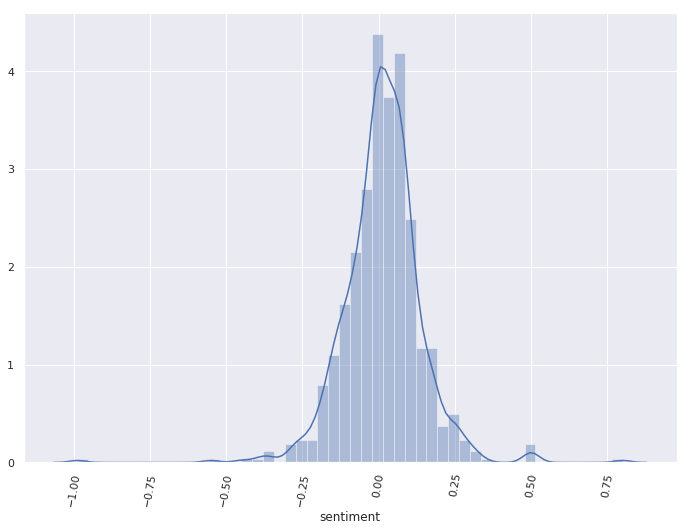

In [24]:

g = sns.distplot(df.sentiment)
for item in g.get_xticklabels():
    item.set_rotation(80)